In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras import callbacks
from keras.preprocessing import text, sequence
import tensorflow as tf

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection

In [ ]:
#load data
data1=pd.read_csv("/content/drive/My Drive/GEARS2022/code/problem_data_multisemester_balanced.csv")
data2=pd.read_csv("/content/drive/My Drive/GEARS2022/code/suggestion_data_multisemester_balanced.csv")

In [ ]:
data1=data1.rename(columns={'TAG':'problem'})
data2=data2.rename(columns={'TAG':'suggestion'})
result = pd.merge(data1, data2, how='inner',on='REVIEW')
result['TAG'] = result['problem'] + result['suggestion']
result['TAG'].loc[ result['TAG'] > 0] = 1
data=result.drop(columns=['problem', 'suggestion'])
data.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,REVIEW,TAG
0,The test plan covers possible test cases and a...,0
1,Multiple diagrams visualizing and explaining t...,0
2,The design is well thought of. They propose 2 ...,0
3,The team has added details about UI testing. \...,1
4,The team has provided a usecase diagram which ...,1


In [ ]:
# Split the data to train data and test data
X_train_tmp, X_test, y_train_tmp, y_test = model_selection.train_test_split(data['REVIEW'],data['TAG'], random_state = 0)
X_train,X_val,y_train,y_val=model_selection.train_test_split(X_train_tmp,y_train_tmp, random_state = 0)

In [ ]:
# Create sequences of tokens uniform in length for all reviews
tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(X_train))
X_train_tok = tokenizer.texts_to_sequences(X_train)
X_train_tok_pad = sequence.pad_sequences(X_train_tok, maxlen=100)

X_val_tok = tokenizer.texts_to_sequences(X_val)
X_val_tok_pad = sequence.pad_sequences(X_val_tok, maxlen=100)

X_test_tok = tokenizer.texts_to_sequences(X_test)
X_test_tok_pad = sequence.pad_sequences(X_test_tok, maxlen=100)

In [ ]:
embedding_size = 128
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(20000, embedding_size,input_shape=(100,)))
model.add(tf.keras.layers.LSTM(25, return_sequences=True))
model.add(tf.keras.layers.LSTM(25, return_sequences=True))
model.add(tf.keras.layers.GlobalMaxPool1D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='relu'))

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          2560000   
                                                                 
 lstm (LSTM)                 (None, 100, 25)           15400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 25)           5100      
                                                                 
 global_max_pooling1d (Globa  (None, 25)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 dense (Dense)               (None, 50)                1300      
                                                        

In [ ]:
history = model.fit(X_train_tok_pad, y_train, epochs=50, batch_size=1024,validation_data=(X_val_tok_pad, y_val))

Epoch 1/50
4/4 [==============================] - 13s 883ms/step - loss: 2.9026 - accuracy: 0.4074 - val_loss: 1.5291 - val_accuracy: 0.4074
Epoch 2/50
4/4 [==============================] - 0s 114ms/step - loss: 1.5034 - accuracy: 0.4074 - val_loss: 1.1801 - val_accuracy: 0.4074
Epoch 3/50
4/4 [==============================] - 0s 93ms/step - loss: 1.1719 - accuracy: 0.4102 - val_loss: 0.9367 - val_accuracy: 0.4074
Epoch 4/50
4/4 [==============================] - 0s 106ms/step - loss: 1.0232 - accuracy: 0.4342 - val_loss: 0.7820 - val_accuracy: 0.4074
Epoch 5/50
4/4 [==============================] - 0s 90ms/step - loss: 1.0527 - accuracy: 0.4750 - val_loss: 0.7428 - val_accuracy: 0.4074
Epoch 6/50
4/4 [==============================] - 0s 94ms/step - loss: 1.0045 - accuracy: 0.4708 - val_loss: 0.7509 - val_accuracy: 0.4074
Epoch 7/50
4/4 [==============================] - 0s 84ms/step - loss: 0.8865 - accuracy: 0.4508 - val_loss: 0.7622 - val_accuracy: 0.4074
Epoch 8/50
4/4 [=======

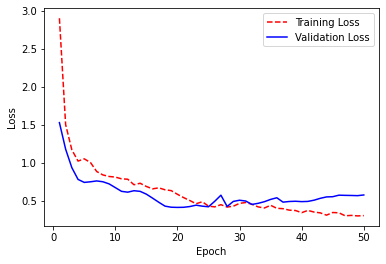

In [ ]:
epoch_count = range(1, len(history.history['loss']) + 1)
plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
model.evaluate(X_test_tok_pad, y_test, batch_size=1024)

2/2 [==============================] - 0s 22ms/step - loss: 0.6611 - accuracy: 0.8542


[0.6610614657402039, 0.8541534543037415]

In [ ]:
# Examine classification report
from sklearn.metrics import classification_report
#y_pred_classes = model.predict_classes(X_test_tok_pad, batch_size=2048)
predict_y=model.predict(X_test_tok_pad, batch_size=2048)
classes_y=np.argmax(predict_y,axis=-1)
print(classification_report(y_test, classes_y))

              precision    recall  f1-score   support

           0       0.39      1.00      0.56       613
           1       0.00      0.00      0.00       964

    accuracy                           0.39      1577
   macro avg       0.19      0.50      0.28      1577
weighted avg       0.15      0.39      0.22      1577



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
